# Predicting Car Crash Severity in the United States
### Analysis Completed by Vaibhav Sanjay, Kashish Patel

# Introduction

Car crashes are one of the largest non-illness causes of fatalities among people in the United States. Analysis of car accidents is useful for locating accident-prone regions, analyzing effects of weather, and predicting accidents. We analyze a countrywide dataset of car accidents to understand patterns in car crashes and predict the severity of them based on various parameters such as precipitation, visibility, temperature, and location.

We used the [US Accidents (2016-2021)](https://www.kaggle.com/datasets/sobhanmoosavi/us-accidents) dataset on Kaggle for our analysis [[1]](#1). The dataset includes 2.8 million points of accident data from February 2016 to December 2021 and covers 49 states.

<span style="color:#b00c00; font-weight:bold; font-size:larger">TO REMOVE</span>

_Dataset:
https://smoosavi.org/datasets/us_accidents_

To-do:
- ~~time graph~~
- ~~state frequency chloropleth~~
- something to do with sunset/sunrise?

# Data Wrangling
This notebook depends on numpy, pandas, matplotlib, plotly, ....

## Reading in the Data
We start by doing the necessary imports and reading in the data. Note that there is a lot of data so this command and several subsequent commands may take some time to complete.

In [35]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from statistics import mode

data_all = pd.read_csv('./US_Accidents_Dec21_updated.csv', nrows=100)
# data_all = pd.read_csv('./US_Accidents_Dec21_updated.csv')
data_all.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,...,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,3,2016-02-08 00:37:08,2016-02-08 06:37:08,40.108910,-83.092860,40.112060,-83.031870,3.230,Between Sawmill Rd/Exit 20 and OH-315/Olentang...,...,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,2,2016-02-08 05:56:20,2016-02-08 11:56:20,39.865420,-84.062800,39.865010,-84.048730,0.747,At OH-4/OH-235/Exit 41 - Accident.,...,False,False,False,False,False,False,Night,Night,Night,Night
2,A-3,2,2016-02-08 06:15:39,2016-02-08 12:15:39,39.102660,-84.524680,39.102090,-84.523960,0.055,At I-71/US-50/Exit 1 - Accident.,...,False,False,False,False,False,False,Night,Night,Night,Day
3,A-4,2,2016-02-08 06:51:45,2016-02-08 12:51:45,41.062130,-81.537840,41.062170,-81.535470,0.123,At Dart Ave/Exit 21 - Accident.,...,False,False,False,False,False,False,Night,Night,Day,Day
4,A-5,3,2016-02-08 07:53:43,2016-02-08 13:53:43,39.172393,-84.492792,39.170476,-84.501798,0.500,At Mitchell Ave/Exit 6 - Accident.,...,False,False,False,False,False,False,Day,Day,Day,Day


The above dataframe has 47 columns. We will not be using all of these columns. Here are the descriptions for all the columns that we are interested in.
1. ID - .....

## Filtering Columns
We remove the rest of the columns. Here are explanations for why each was removed.
1. The "Description" column is too messy and does not provide much useful information.
2. The "Number", "Street", "Side", "County", "Zipcode", "Timezone", and "Airport_Code" columns all provide location information that is not as specific as latitude, longitude and city. The "Country" column is not useful since this data is for the USA.
3. The "Weather timestamp" column shows the timestamp that weather data is collected. This is not very significant.
4. The "Nautical_Twilight" and "Astronomical_Twilight" columns are different measure for when sunset occurs, which we decided to just use the sunset measure to keep everything consistent.

In [31]:

# get data
to_remove = ["Description", "Number", "Street", "Side", "County","Country", "Zipcode", 
    "Timezone", "Airport_Code", "Weather_Timestamp", "Nautical_Twilight", 
    "Astronomical_Twilight"]

data = data_all.drop(to_remove, axis=1, errors='ignore')

Also, it was reported that there was an error in the end times where the duration of each accident was always exactly 6 hours. Here, we will confirm that this information is correct and up to date.

In [32]:
# convert Start_Time and End_Time to datetime objects
data['Start_Time'] = pd.to_datetime(data['Start_Time'])
data['End_Time'] = pd.to_datetime(data['End_Time'])

# check difference between start and end time
durations = data['End_Time'] - data['Start_Time']
durations.unique()

array([ 21600000000000,  32400000000000,  23884000000000, ...,
       376634000000000, 248399000000000, 345584000000000],
      dtype='timedelta64[ns]')

*NOTE: DATA BEYOND THE FIRST 100 ROWS DO NOT HAVE INCORRECT END TIMES*

It seems like the report is correct, so we will drop the End_Time column as it does not provide any new (or correct) information.

In [4]:
data = data.drop('End_Time', axis=1, errors='ignore')

## Encoding

In [5]:
# one hot encoding cell
data['Roundabout'] = data['Roundabout'].apply(int)

# Data Exploration

## Graphing Accident Locations
We are given the state acronyms for every accident with the "State" column. Using this data, we create a chloropleth plot for the frequency of car accidents across the United States.

In [33]:
# Change the value_counts into a DataFrame with each row being a state and its number of accidents
freqs = data['State'].value_counts().rename_axis('State').reset_index(name='Accidents')

# Create the figure
fig = px.choropleth(
        freqs,
        locations='State',
        color='Accidents',
        locationmode='USA-states',
        color_continuous_scale='reds',
        title='Frequency of Car Accidents in the US (2016-2021)',
        scope='usa'
)

# Show figure
fig.show()

[Analysis]

Note: Mention how data may be biased since some states may just be better at recording car accidents

## Graphing Accident Times
Next, we will take advantage of the time-related data to explore when most accidents happen.

For our last time-related plot, we will make a violin plot that combines the two previous plots by displaying each day of the week as a separate violin, each as a mini-time series showing when accidents occur most frequently. To do this, we will need to group the data by the day of week first, then collect the hours of each observation for each of these groups.

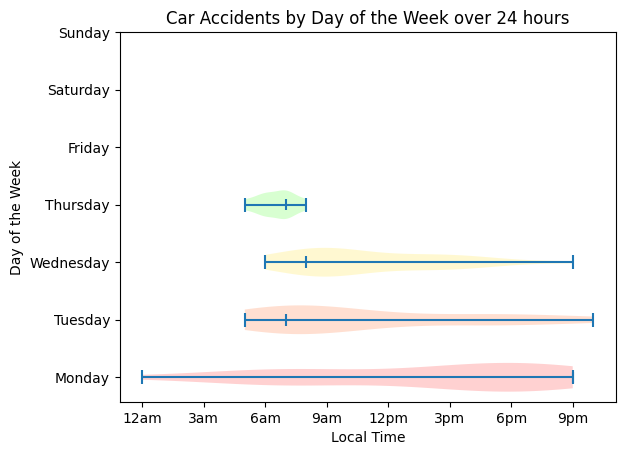

In [9]:
# not sure if this will be useful but ima do it bc why not

# create a list of lists with each inner list representing a different day of the week that contains the hours that an accident occurs
data['Day'] = data['Start_Time'].apply(lambda x: x.dayofweek)
grouped_by_day = data.groupby(by='Day')
hour_foreach_day = grouped_by_day.apply(lambda x: x['Hour'].tolist()).tolist()

# create the violin plot
fig, ax = plt.subplots()
violins = ax.violinplot(dataset=hour_foreach_day, positions=range(len(hour_foreach_day)), vert=False)

# add lines marking the mode for each day, representing the time where most accidents happen
bodies = violins['bodies']
modes = [mode(x) for x in hour_foreach_day]
ax.vlines(modes, list(map(lambda x: x-0.1, range(len(bodies)))), list(map(lambda x: x+0.1, range(len(bodies)))))

# add colors to help differentiate each violin
colors = ["#ff6969", "#ff9869", "#ffeb69", "#7fff69", "#69c8ff", "#9669ff", "#ff69c5"]
for i in range(len(bodies)):
    bodies[i].set_facecolor(colors[i])

# add labels to plot
plt.yticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
plt.title("Car Accidents by Day of the Week over 24 hours")
plt.xlabel("Local Time")
plt.ylabel("Day of the Week")
plt.xticks(ticks=[0, 3, 6, 9, 12, 15, 18, 21], labels=["12am", "3am", "6am", "9am", "12pm", "3pm", "6pm", "9pm"])
plt.show()

## Graphing Accident Weather

In [29]:
weather_features = ['Temperature(F)',
       'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)',
       'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)',
       'Weather_Condition']
# plt.scatter(x=data['Humidity(%)'], y=data['Precipitation(in)'])
# plt.show()

# def plot_freqs(feature):
#     counts = data[feature].value_counts()
#     plt.scatter(x=counts.index, y=counts)
#     plt.title(feature)
#     plt.show()
# 
# for feat in weather_features:
#     plot_freqs(feat)

data['Weather_Condition'].unique()

array(['Light Rain', 'Overcast', 'Mostly Cloudy', 'Snow', 'Light Snow',
       'Cloudy', nan, 'Scattered Clouds', 'Clear'], dtype=object)

# Citations
- <a id="1">[1]</a> 
Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, and Rajiv Ramnath. “A Countrywide Traffic Accident Dataset.”, 2019.
- <a id="2">[2]</a> 
Moosavi, Sobhan, Mohammad Hossein Samavatian, Srinivasan Parthasarathy, Radu Teodorescu, and Rajiv Ramnath. "Accident Risk Prediction based on Heterogeneous Sparse Data: New Dataset and Insights." In proceedings of the 27th ACM SIGSPATIAL International Conference on Advances in Geographic Information Systems, ACM, 2019.